In [39]:
import IPython

import random
import scipy
import numpy as np # manipulate N-dimensional arrays
import pandas as pd # data frame
import matplotlib.pyplot as plt # data plotting
import seaborn as sns # advanced data plotting
from sklearn import preprocessing # basic ML models
# import scipy # scientific computing library

import tensorflow as tf
import keras
import sklearn as sk

from collections import Counter # Permet de compter le nombre d'éléments qui possèdent chaque label
from keras.utils import to_categorical # One-hot encoding

from keras.models import Model, Sequential
from keras.layers import Input, Dense, BatchNormalization, Dropout, ReLU, Activation, Flatten, Conv2D, MaxPooling2D,LeakyReLU

from keras.backend import clear_session
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping

import os
from keras import backend as K

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from keras.utils import plot_model

from tqdm import tqdm #progress bar


In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Préparation des données

In [41]:
data = pd.read_csv("/content/drive/My Drive/stanford-covid-vaccine/data_train.csv")

In [42]:
data.head()

,Unnamed: 0,id,sequence,index_sequence,seq_be,seq_af,structure,struct_be,struct_af,predicted_loop_type,loop_type_be,loop_type_af,bpps_0,bpps_1,bpps_2,bpps_3,bpps_4,bpps_5,bpps_6,bpps_7,bpps_8,bpps_9,bpps_10,bpps_11,bpps_12,bpps_13,bpps_14,bpps_15,bpps_16,bpps_17,bpps_18,bpps_19,bpps_20,bpps_21,bpps_22,bpps_23,bpps_24,bpps_25,bpps_26,bpps_27,...,bpps_74,bpps_75,bpps_76,bpps_77,bpps_78,bpps_79,bpps_80,bpps_81,bpps_82,bpps_83,bpps_84,bpps_85,bpps_86,bpps_87,bpps_88,bpps_89,bpps_90,bpps_91,bpps_92,bpps_93,bpps_94,bpps_95,bpps_96,bpps_97,bpps_98,bpps_99,bpps_100,bpps_101,bpps_102,bpps_103,bpps_104,bpps_105,bpps_106,signal_to_noise,SN_filter,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081_0,G,1,O,G,.,O,.,E,O,E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006554,0.009221,0.008094,0.021786,0.0,0.0,0.0,0.0,0.0,0.00112,0.0,0.0,0.0,0.0,0.0,0.0,0.004653,0.002415,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.001411,0.0,0.002758,0.005980,0.005979,0.013887,0.0,0.0,0.001528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009526,0.0,0.0,0.011146,0.0,0.0,0.011636,0.0,0.0,0.010538,0.0,0.0,0.014674,6.894,1,0.3297,0.7556,2.3375,0.3581,0.6382
1,1,id_001f94081_1,G,2,G,A,.,.,.,E,E,E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018205,0.005112,0.038653,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.004323,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.004437,0.0,0.009695,0.003770,0.022915,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005783,0.0,0.0,0.006336,0.0,0.0,0.006032,0.0,0.0,0.005633,0.0,0.0,0.006204,6.894,1,1.5693,2.9830,3.5060,2.9683,3.4773
2,2,id_001f94081_2,A,3,G,A,.,.,.,E,E,E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.027590,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.002879,0.000000,0.0,0.000000,0.017502,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,6.894,1,1.1227,0.2526,0.3008,0.2589,0.9988
3,3,id_001f94081_3,A,4,A,A,.,.,.,E,E,E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.001278,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,6.894,1,0.8686,1.3789,1.0108,1.4552,1.3228
4,4,id_001f94081_4,A,5,A,A,.,.,(,E,E,S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.002843,0.0,0.0,0.0,...,0.0,0.0,0.001408,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,6.894,1,0.7217,0.6376,0.2635,0.7244,0.7877


On ne prend pas les variables suivantes pour deux raisons :

*   Unnamed: 0
*   id
*   index_sequence
*   signal_to_noise	
*   SN_filter	





In [43]:
cols = ['sequence','seq_be','seq_af','structure',	'struct_be',	'struct_af',	'predicted_loop_type',	'loop_type_be',	'loop_type_af']
df=pd.DataFrame()
for name in cols:
  df=pd.concat([df,pd.get_dummies(data[name], prefix=name)],axis=1)
df.head()

,sequence_A,sequence_C,sequence_G,sequence_U,seq_be_A,seq_be_C,seq_be_G,seq_be_O,seq_be_U,seq_af_A,seq_af_C,seq_af_G,seq_af_O,seq_af_U,structure_(,structure_),structure_.,struct_be_(,struct_be_),struct_be_.,struct_be_O,struct_af_(,struct_af_),struct_af_.,struct_af_O,predicted_loop_type_B,predicted_loop_type_E,predicted_loop_type_H,predicted_loop_type_I,predicted_loop_type_M,predicted_loop_type_S,predicted_loop_type_X,loop_type_be_B,loop_type_be_E,loop_type_be_H,loop_type_be_I,loop_type_be_M,loop_type_be_O,loop_type_be_S,loop_type_be_X,loop_type_af_B,loop_type_af_E,loop_type_af_H,loop_type_af_I,loop_type_af_M,loop_type_af_O,loop_type_af_S,loop_type_af_X
0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [44]:
#data=data[data['SN_filter']==1]

In [45]:
cols=list(df.columns)
for i in range(107):
  cols.append('bpps_'+str(i))
  df['bpps_'+str(i)] = data['bpps_'+str(i)].astype('float32')

In [46]:
X = df[cols]
Y = data[["reactivity",	"deg_Mg_pH10"	,"deg_pH10"	,"deg_Mg_50C",	"deg_50C"]].astype('float32')

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2,stratify=data['index_sequence'])

In [48]:
X_train=np.asarray(X_train)
y_train=np.asarray(y_train)

X_val=np.asarray(X_val)
y_val=np.asarray(y_val)

In [49]:
print(X_train.shape)
dim_x=X_train.shape[1]

(130560, 155)


In [50]:
del data, df

# Modèle MLP

In [92]:
clear_session()

In [93]:
def model_MLP():
    model = Sequential()

    model.add(Dense(512, use_bias=True, input_shape=(dim_x,)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.5))

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.5))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.5))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.5))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.5))

    model.add(Dense(5,use_bias=True, input_shape=(256,)))
    return model

In [94]:
 def mcrmse(y_true, y_pred):
        cmse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
        res = float(tf.reduce_mean(tf.sqrt(cmse)))
        return res

In [95]:
def MLP_loss(y_true,y_pred):
    return mcrmse(y_true, y_pred)

In [96]:
MLP_optimizer = tf.keras.optimizers.Adam(lr=1e-3)

In [97]:
@tf.function
def train_step(x_data,y_data):

    with tf.GradientTape() as MLP_tape:
      y_pred=MLP(x_data,training=True)

      mlp_loss = MLP_loss(y_data,y_pred)

    gradients_of_MLP = MLP_tape.gradient(mlp_loss, MLP.trainable_variables)

    MLP_optimizer.apply_gradients(zip(gradients_of_MLP, MLP.trainable_variables))

In [98]:
EPOCHS = 50
BATCH_SIZE = 256
BUFFER_SIZE = X_train.shape[0]

MLP = model_MLP()
print(MLP.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               79872     
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
re_lu (ReLU)                 (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0

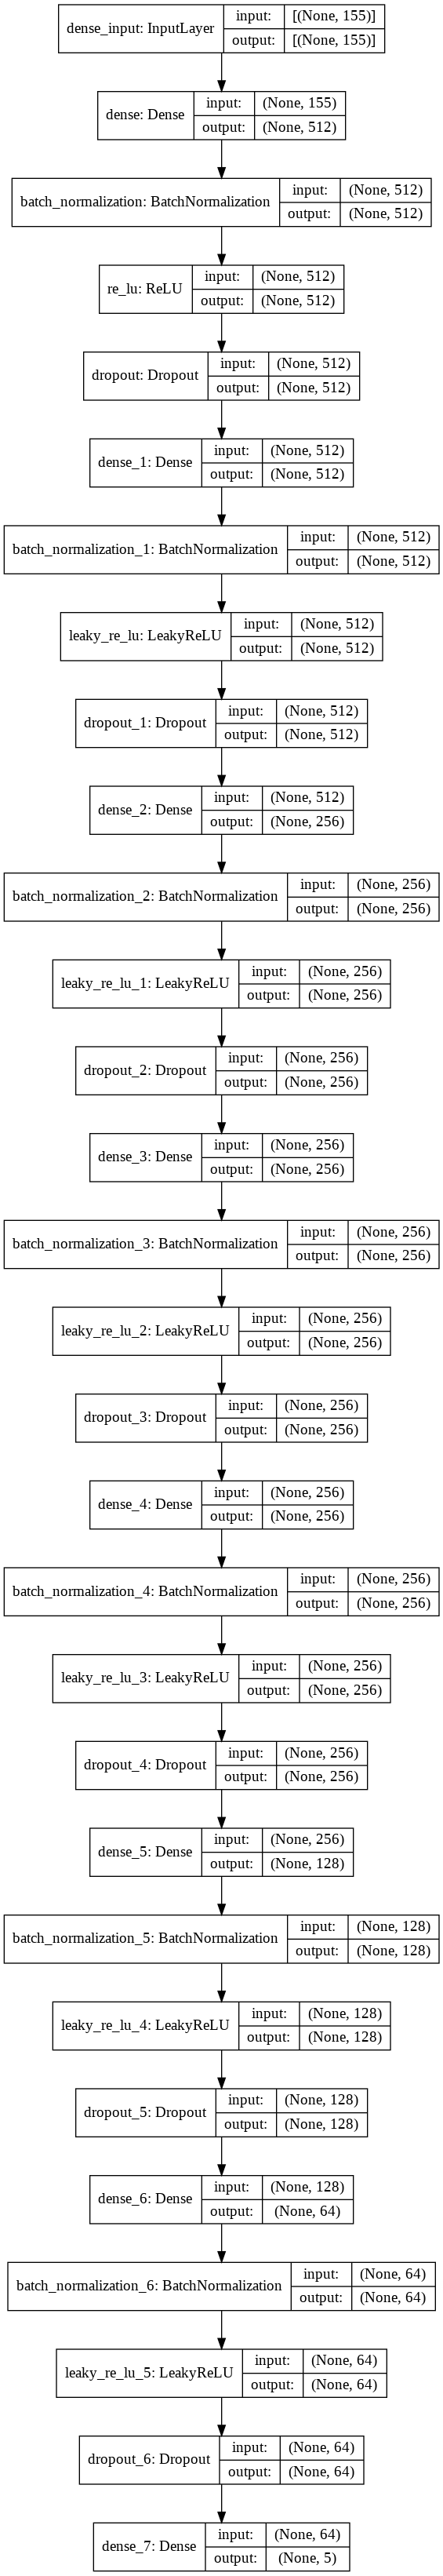

In [99]:
plot_model(MLP,show_shapes=True)

In [100]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [101]:
#idx_history=0
for epoch in tqdm(np.arange(0,EPOCHS)):
  for x_batch,y_batch in train_dataset:
      train_step(x_batch,y_batch)
  y_pred_val=MLP(X_val,training=False)
  print(mcrmse(y_val,y_pred_val))


  2%|▏         | 1/50 [00:03<02:53,  3.55s/it]

0.3605978488922119



  4%|▍         | 2/50 [00:05<02:30,  3.13s/it]

0.3484077751636505



  6%|▌         | 3/50 [00:07<02:13,  2.85s/it]

0.3433302938938141



  8%|▊         | 4/50 [00:10<02:04,  2.70s/it]

0.34003281593322754



 10%|█         | 5/50 [00:12<01:57,  2.61s/it]

0.338662713766098



 12%|█▏        | 6/50 [00:14<01:49,  2.50s/it]

0.33597439527511597



 14%|█▍        | 7/50 [00:16<01:42,  2.37s/it]

0.33598488569259644



 16%|█▌        | 8/50 [00:19<01:36,  2.29s/it]

0.33560043573379517



 18%|█▊        | 9/50 [00:21<01:33,  2.27s/it]

0.3353794515132904



 20%|██        | 10/50 [00:23<01:30,  2.25s/it]

0.33268484473228455



 22%|██▏       | 11/50 [00:25<01:27,  2.25s/it]

0.3327007591724396



 24%|██▍       | 12/50 [00:27<01:23,  2.21s/it]

0.3321792781352997



 26%|██▌       | 13/50 [00:30<01:21,  2.20s/it]

0.3306030035018921



 28%|██▊       | 14/50 [00:32<01:18,  2.18s/it]

0.3336470425128937



 30%|███       | 15/50 [00:34<01:16,  2.18s/it]

0.3305773138999939



 32%|███▏      | 16/50 [00:36<01:13,  2.16s/it]

0.3312731087207794



 34%|███▍      | 17/50 [00:38<01:13,  2.23s/it]

0.3297879099845886



 36%|███▌      | 18/50 [00:41<01:13,  2.30s/it]

0.3303696811199188



 38%|███▊      | 19/50 [00:43<01:09,  2.24s/it]

0.32883355021476746



 40%|████      | 20/50 [00:45<01:06,  2.23s/it]

0.3302886486053467



 42%|████▏     | 21/50 [00:47<01:03,  2.20s/it]

0.32817310094833374



 44%|████▍     | 22/50 [00:50<01:02,  2.25s/it]

0.3282269537448883



 46%|████▌     | 23/50 [00:52<01:03,  2.33s/it]

0.328362375497818



 48%|████▊     | 24/50 [00:54<00:59,  2.28s/it]

0.32823964953422546



 50%|█████     | 25/50 [00:56<00:56,  2.25s/it]

0.3277195692062378



 52%|█████▏    | 26/50 [00:59<00:53,  2.23s/it]

0.3282147943973541



 54%|█████▍    | 27/50 [01:01<00:52,  2.28s/it]

0.32730334997177124



 56%|█████▌    | 28/50 [01:03<00:50,  2.32s/it]

0.32782191038131714



 58%|█████▊    | 29/50 [01:06<00:48,  2.32s/it]

0.32716649770736694



 60%|██████    | 30/50 [01:08<00:47,  2.36s/it]

0.32684189081192017



 62%|██████▏   | 31/50 [01:11<00:44,  2.35s/it]

0.3279666304588318



 64%|██████▍   | 32/50 [01:13<00:41,  2.32s/it]

0.32621118426322937



 66%|██████▌   | 33/50 [01:15<00:40,  2.37s/it]

0.3274053931236267



 68%|██████▊   | 34/50 [01:17<00:37,  2.31s/it]

0.3260144293308258



 70%|███████   | 35/50 [01:20<00:33,  2.26s/it]

0.3264859616756439



 72%|███████▏  | 36/50 [01:22<00:32,  2.29s/it]

0.32628095149993896



 74%|███████▍  | 37/50 [01:24<00:29,  2.27s/it]

0.3261248469352722



 76%|███████▌  | 38/50 [01:26<00:27,  2.27s/it]

0.3265661895275116



 78%|███████▊  | 39/50 [01:29<00:25,  2.32s/it]

0.3266535997390747



 80%|████████  | 40/50 [01:31<00:22,  2.29s/it]

0.32533469796180725



 82%|████████▏ | 41/50 [01:33<00:20,  2.25s/it]

0.3254397213459015



 84%|████████▍ | 42/50 [01:35<00:17,  2.21s/it]

0.3258201479911804



 86%|████████▌ | 43/50 [01:38<00:15,  2.22s/it]

0.32600122690200806



 88%|████████▊ | 44/50 [01:40<00:13,  2.27s/it]

0.32523050904273987



 90%|█████████ | 45/50 [01:42<00:11,  2.29s/it]

0.32564228773117065



 92%|█████████▏| 46/50 [01:45<00:09,  2.33s/it]

0.3250802457332611



 94%|█████████▍| 47/50 [01:47<00:07,  2.34s/it]

0.3257597088813782



 96%|█████████▌| 48/50 [01:50<00:04,  2.41s/it]

0.32576215267181396



 98%|█████████▊| 49/50 [01:52<00:02,  2.35s/it]

0.3246729373931885



100%|██████████| 50/50 [01:54<00:00,  2.30s/it]

0.32475337386131287


## Prédiction sur la partie Test

In [26]:
data_test = pd.read_csv("/content/drive/My Drive/stanford-covid-vaccine/data_test.csv")
data_test.head()

,Unnamed: 0,id,sequence,index_sequence,seq_be,seq_af,structure,struct_be,struct_af,predicted_loop_type,loop_type_be,loop_type_af,bpps_0,bpps_1,bpps_2,bpps_3,bpps_4,bpps_5,bpps_6,bpps_7,bpps_8,bpps_9,bpps_10,bpps_11,bpps_12,bpps_13,bpps_14,bpps_15,bpps_16,bpps_17,bpps_18,bpps_19,bpps_20,bpps_21,bpps_22,bpps_23,bpps_24,bpps_25,bpps_26,bpps_27,...,bpps_67,bpps_68,bpps_69,bpps_70,bpps_71,bpps_72,bpps_73,bpps_74,bpps_75,bpps_76,bpps_77,bpps_78,bpps_79,bpps_80,bpps_81,bpps_82,bpps_83,bpps_84,bpps_85,bpps_86,bpps_87,bpps_88,bpps_89,bpps_90,bpps_91,bpps_92,bpps_93,bpps_94,bpps_95,bpps_96,bpps_97,bpps_98,bpps_99,bpps_100,bpps_101,bpps_102,bpps_103,bpps_104,bpps_105,bpps_106
0,0,id_00073f8be_0,G,1,O,G,.,O,.,E,O,E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000485,0.0,0.004354,0.0,0.0,0.000142,0.000014,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000062,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005264,0.0,0.0,0.005525,0.0,0.0,0.007086,0.0,0.0,0.007222,0.0,0.0,0.000464
1,1,id_00073f8be_1,G,2,G,A,.,.,.,E,E,E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000176,0.0,0.000234,0.0,0.0,0.000031,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000043,0.000113,0.0,0.0,0.0,0.0,0.000000,0.0,0.000023,0.000160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001451,0.0,0.0,0.001528,0.0,0.0,0.001668,0.0,0.0,0.001664,0.0,0.0,0.000178
2,2,id_00073f8be_2,A,3,G,A,.,.,.,E,E,E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000238,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000035,0.000097,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000137,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
3,3,id_00073f8be_3,A,4,A,A,.,.,.,E,E,E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000076,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000067,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
4,4,id_00073f8be_4,A,5,A,A,.,.,.,E,E,E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000018,0.002343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000049,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000


In [27]:
cols = ['sequence','seq_be','seq_af','structure',	'struct_be',	'struct_af',	'predicted_loop_type',	'loop_type_be',	'loop_type_af']
df=pd.DataFrame()
for name in cols:
  df=pd.concat([df,pd.get_dummies(data_test[name], prefix=name)],axis=1)
df.head()

,sequence_A,sequence_C,sequence_G,sequence_U,seq_be_A,seq_be_C,seq_be_G,seq_be_O,seq_be_U,seq_af_A,seq_af_C,seq_af_G,seq_af_O,seq_af_U,structure_(,structure_),structure_.,struct_be_(,struct_be_),struct_be_.,struct_be_O,struct_af_(,struct_af_),struct_af_.,struct_af_O,predicted_loop_type_B,predicted_loop_type_E,predicted_loop_type_H,predicted_loop_type_I,predicted_loop_type_M,predicted_loop_type_S,predicted_loop_type_X,loop_type_be_B,loop_type_be_E,loop_type_be_H,loop_type_be_I,loop_type_be_M,loop_type_be_O,loop_type_be_S,loop_type_be_X,loop_type_af_B,loop_type_af_E,loop_type_af_H,loop_type_af_I,loop_type_af_M,loop_type_af_O,loop_type_af_S,loop_type_af_X
0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [28]:
cols=list(df.columns)
for i in range(107):
  cols.append('bpps_'+str(i))
  df['bpps_'+str(i)] = data_test['bpps_'+str(i)].astype('float32')

In [29]:
X_test = df[cols]
X_test = np.array(X_test)
print(X_test)

[[0.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 4.6445747e-04]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 1.7784732e-04]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]


In [30]:
X = np.array(X)
print(X)
Y = np.array(Y)
print(Y)

[[0.         0.         1.         ... 0.         0.         0.0146736 ]
 [0.         0.         1.         ... 0.         0.         0.00620374]
 [1.         0.         0.         ... 0.         0.         0.        ]
 ...
 [1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]]
[[ 0.3297  0.7556  2.3375  0.3581  0.6382]
 [ 1.5693  2.983   3.506   2.9683  3.4773]
 [ 1.1227  0.2526  0.3008  0.2589  0.9988]
 ...
 [ 0.0381  0.1827  0.1642  0.2047  0.112 ]
 [-0.0066  0.3261  0.1654  0.2447  0.1186]
 [ 0.0706  0.4529  0.484   0.1802  0.3013]]


In [31]:
clear_session()
EPOCHS = 100
BATCH_SIZE = 256
BUFFER_SIZE = X.shape[0]
MLP = model_MLP()
MLP_optimizer = tf.keras.optimizers.Adam(lr=1e-3)

In [32]:
@tf.function
def train_step(x_data,y_data):

    with tf.GradientTape() as MLP_tape:
      y_pred=MLP(x_data,training=True)

      mlp_loss = MLP_loss(y_data,y_pred)

    gradients_of_MLP = MLP_tape.gradient(mlp_loss, MLP.trainable_variables)

    MLP_optimizer.apply_gradients(zip(gradients_of_MLP, MLP.trainable_variables))

In [33]:
train_dataset = tf.data.Dataset.from_tensor_slices((X,Y)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
for epoch in tqdm(np.arange(0,EPOCHS)):
  for x_batch,y_batch in train_dataset:
      train_step(x_batch,y_batch)
  y_pred=MLP(X,training=False)
  print(mcrmse(Y,y_pred))

  1%|          | 1/100 [00:03<06:28,  3.93s/it]

0.35686689615249634


  2%|▏         | 2/100 [00:06<05:36,  3.44s/it]

0.3420386016368866


  3%|▎         | 3/100 [00:08<05:03,  3.12s/it]

0.3366643786430359


  4%|▍         | 4/100 [00:10<04:37,  2.89s/it]

0.3347328305244446


  5%|▌         | 5/100 [00:13<04:27,  2.81s/it]

0.3329698145389557


  6%|▌         | 6/100 [00:15<04:12,  2.69s/it]

0.33167317509651184


  7%|▋         | 7/100 [00:18<04:06,  2.66s/it]

0.3324751555919647


  8%|▊         | 8/100 [00:20<03:58,  2.59s/it]

0.33196529746055603


  9%|▉         | 9/100 [00:23<03:47,  2.50s/it]

0.32969337701797485


 10%|█         | 10/100 [00:25<03:45,  2.50s/it]

0.3293673098087311


 11%|█         | 11/100 [00:28<03:41,  2.49s/it]

0.3294558525085449


 12%|█▏        | 12/100 [00:30<03:44,  2.55s/it]

0.32990360260009766


 13%|█▎        | 13/100 [00:33<03:39,  2.52s/it]

0.3289942741394043


 14%|█▍        | 14/100 [00:36<03:41,  2.57s/it]

0.3275795578956604


 15%|█▌        | 15/100 [00:38<03:34,  2.53s/it]

0.3274039626121521


 16%|█▌        | 16/100 [00:41<03:32,  2.53s/it]

0.3273201882839203


 17%|█▋        | 17/100 [00:43<03:35,  2.59s/it]

0.32773858308792114


 18%|█▊        | 18/100 [00:46<03:29,  2.55s/it]

0.3255281150341034


 19%|█▉        | 19/100 [00:48<03:28,  2.57s/it]

0.32634302973747253


 20%|██        | 20/100 [00:51<03:23,  2.54s/it]

0.3253544270992279


 21%|██        | 21/100 [00:53<03:15,  2.48s/it]

0.3252254128456116


 22%|██▏       | 22/100 [00:56<03:10,  2.45s/it]

0.32471325993537903


 23%|██▎       | 23/100 [00:58<03:07,  2.43s/it]

0.32453832030296326


 24%|██▍       | 24/100 [01:00<03:03,  2.42s/it]

0.3232864737510681


 25%|██▌       | 25/100 [01:03<03:00,  2.40s/it]

0.32418712973594666


 26%|██▌       | 26/100 [01:05<03:01,  2.45s/it]

0.3230017423629761


 27%|██▋       | 27/100 [01:08<03:00,  2.48s/it]

0.32312989234924316


 28%|██▊       | 28/100 [01:10<02:58,  2.48s/it]

0.32294511795043945


 29%|██▉       | 29/100 [01:13<02:58,  2.51s/it]

0.3225165009498596


 30%|███       | 30/100 [01:15<02:56,  2.52s/it]

0.3222233057022095


 31%|███       | 31/100 [01:18<02:53,  2.52s/it]

0.32294243574142456


 32%|███▏      | 32/100 [01:20<02:50,  2.50s/it]

0.32154032588005066


 33%|███▎      | 33/100 [01:23<02:43,  2.45s/it]

0.3215404152870178


 34%|███▍      | 34/100 [01:25<02:41,  2.45s/it]

0.32127702236175537


 35%|███▌      | 35/100 [01:28<02:39,  2.46s/it]

0.3221273124217987


 36%|███▌      | 36/100 [01:30<02:34,  2.42s/it]

0.3213593363761902


 37%|███▋      | 37/100 [01:32<02:32,  2.42s/it]

0.3206397294998169


 38%|███▊      | 38/100 [01:35<02:30,  2.42s/it]

0.3209225535392761


 39%|███▉      | 39/100 [01:37<02:27,  2.42s/it]

0.32063066959381104


 40%|████      | 40/100 [01:40<02:23,  2.39s/it]

0.3213081955909729


 41%|████      | 41/100 [01:42<02:19,  2.36s/it]

0.3206104338169098


 42%|████▏     | 42/100 [01:44<02:18,  2.39s/it]

0.32183998823165894


 43%|████▎     | 43/100 [01:47<02:17,  2.41s/it]

0.32198160886764526


 44%|████▍     | 44/100 [01:49<02:20,  2.51s/it]

0.31972548365592957


 45%|████▌     | 45/100 [01:52<02:18,  2.53s/it]

0.31880393624305725


 46%|████▌     | 46/100 [01:55<02:17,  2.55s/it]

0.31917065382003784


 47%|████▋     | 47/100 [01:57<02:18,  2.61s/it]

0.3187270760536194


 48%|████▊     | 48/100 [02:00<02:10,  2.51s/it]

0.31850290298461914


 49%|████▉     | 49/100 [02:02<02:11,  2.58s/it]

0.320095419883728


 50%|█████     | 50/100 [02:05<02:07,  2.56s/it]

0.31873688101768494


 51%|█████     | 51/100 [02:07<02:03,  2.53s/it]

0.31794995069503784


 52%|█████▏    | 52/100 [02:10<02:01,  2.54s/it]

0.3184841275215149


 53%|█████▎    | 53/100 [02:12<01:56,  2.49s/it]

0.3202194273471832


 54%|█████▍    | 54/100 [02:15<01:52,  2.45s/it]

0.31816062331199646


 55%|█████▌    | 55/100 [02:17<01:48,  2.42s/it]

0.3174906075000763


 56%|█████▌    | 56/100 [02:19<01:44,  2.39s/it]

0.317339688539505


 57%|█████▋    | 57/100 [02:22<01:42,  2.39s/it]

0.3180169463157654


 58%|█████▊    | 58/100 [02:24<01:40,  2.40s/it]

0.31706470251083374


 59%|█████▉    | 59/100 [02:27<01:38,  2.39s/it]

0.3176098167896271


 60%|██████    | 60/100 [02:29<01:36,  2.42s/it]

0.3169797956943512


 61%|██████    | 61/100 [02:32<01:39,  2.54s/it]

0.318173348903656


 62%|██████▏   | 62/100 [02:34<01:34,  2.49s/it]

0.31718602776527405


 63%|██████▎   | 63/100 [02:37<01:32,  2.49s/it]

0.3174786865711212


 64%|██████▍   | 64/100 [02:39<01:29,  2.48s/it]

0.3182815611362457


 65%|██████▌   | 65/100 [02:42<01:26,  2.47s/it]

0.31651830673217773


 66%|██████▌   | 66/100 [02:44<01:22,  2.41s/it]

0.31859588623046875


 67%|██████▋   | 67/100 [02:46<01:19,  2.42s/it]

0.3160310983657837


 68%|██████▊   | 68/100 [02:49<01:19,  2.50s/it]

0.31705471873283386


 69%|██████▉   | 69/100 [02:51<01:17,  2.49s/it]

0.31556156277656555


 70%|███████   | 70/100 [02:54<01:15,  2.50s/it]

0.31584811210632324


 71%|███████   | 71/100 [02:57<01:13,  2.53s/it]

0.3156764507293701


 72%|███████▏  | 72/100 [02:59<01:09,  2.50s/it]

0.31652888655662537


 73%|███████▎  | 73/100 [03:01<01:06,  2.48s/it]

0.31631261110305786


 74%|███████▍  | 74/100 [03:04<01:03,  2.44s/it]

0.3156987428665161


 75%|███████▌  | 75/100 [03:06<01:00,  2.44s/it]

0.31491750478744507


 76%|███████▌  | 76/100 [03:09<00:57,  2.39s/it]

0.3177252411842346


 77%|███████▋  | 77/100 [03:11<00:55,  2.42s/it]

0.31514012813568115


 78%|███████▊  | 78/100 [03:13<00:53,  2.43s/it]

0.31564173102378845


 79%|███████▉  | 79/100 [03:16<00:51,  2.45s/it]

0.31503504514694214


 80%|████████  | 80/100 [03:18<00:48,  2.42s/it]

0.3162042498588562


 81%|████████  | 81/100 [03:21<00:46,  2.47s/it]

0.31453225016593933


 82%|████████▏ | 82/100 [03:23<00:44,  2.46s/it]

0.3149039149284363


 83%|████████▎ | 83/100 [03:26<00:41,  2.44s/it]

0.3152754008769989


 84%|████████▍ | 84/100 [03:28<00:39,  2.49s/it]

0.31431856751441956


 85%|████████▌ | 85/100 [03:31<00:38,  2.60s/it]

0.31612157821655273


 86%|████████▌ | 86/100 [03:34<00:36,  2.57s/it]

0.31408581137657166


 87%|████████▋ | 87/100 [03:36<00:34,  2.63s/it]

0.31367000937461853


 88%|████████▊ | 88/100 [03:39<00:32,  2.70s/it]

0.3138997256755829


 89%|████████▉ | 89/100 [03:42<00:28,  2.60s/it]

0.3155571222305298


 90%|█████████ | 90/100 [03:44<00:25,  2.54s/it]

0.3133113980293274


 91%|█████████ | 91/100 [03:46<00:22,  2.48s/it]

0.31320446729660034


 92%|█████████▏| 92/100 [03:49<00:19,  2.47s/it]

0.3146558701992035


 93%|█████████▎| 93/100 [03:51<00:17,  2.45s/it]

0.31396734714508057


 94%|█████████▍| 94/100 [03:54<00:14,  2.41s/it]

0.3141913115978241


 95%|█████████▌| 95/100 [03:56<00:12,  2.45s/it]

0.3139338195323944


 96%|█████████▌| 96/100 [03:59<00:09,  2.45s/it]

0.31419461965560913


 97%|█████████▋| 97/100 [04:01<00:07,  2.47s/it]

0.3129328489303589


 98%|█████████▊| 98/100 [04:03<00:04,  2.42s/it]

0.312308669090271


 99%|█████████▉| 99/100 [04:06<00:02,  2.39s/it]

0.31267136335372925


100%|██████████| 100/100 [04:08<00:00,  2.49s/it]

0.31214427947998047


In [34]:
Y_pred_test = MLP(X_test,training=False)

In [35]:
submission = pd.read_csv("/content/drive/My Drive/stanford-covid-vaccine/sample_submission.csv")

In [36]:
submission.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0


In [37]:
submission.iloc[:,1::]=Y_pred_test
submission.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.545130,0.607211,1.968350,0.474382,0.644415
1,id_00073f8be_1,1.453225,2.063013,2.883523,1.953644,1.839530
2,id_00073f8be_2,0.915640,0.607297,0.740103,0.806049,0.853246
3,id_00073f8be_3,0.546763,0.389138,0.469809,0.514560,0.578165
4,id_00073f8be_4,0.545770,0.388562,0.468720,0.513362,0.577069


In [38]:
submission.to_csv("/content/drive/My Drive/stanford-covid-vaccine/Soumission_MLP.csv",index=False)